In [3]:
import os
import sys
sys.path.append('../../')

In [266]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler, StandardScaler, PowerTransformer
import math

In [164]:
from src.utils import get_db_con
from src.analysis_functions import (
    get_all_decisions, groups, schemas, users, dps, dt, pdr, group_order, colors, 
    assign_conf_mat_cell, _modify_value_and_time
)

In [5]:
cred_file = '../../conf/credentials.yaml'
conn = get_db_con(cred_file)

#### Parameter initialization

In [8]:
params={
    'fn': -3, 
    'p_loss_trx': 0.5, # prob of losing this transaction
    'cust_worth': 3, # The long term customer worth as a coefficiant of the trx val
    'p_loss_cust': 0.1, # probablity of losing the customer due to the rejection
    'p_return_cust': 1, # probability of the customer creating future worth as we expect
    'suspicious_add_time': 600
}

#### Fetching all decisions

In [233]:
%%capture
all_decisions = get_all_decisions(conn, schemas, users, groups)
all_decisions['conf_cell'] = assign_conf_mat_cell(all_decisions, suspicious_strategy='correct') 

all_decisions = _modify_value_and_time(all_decisions, params, 'correct')

msk = all_decisions['trx_amnt'] > 0 

all_decisions = all_decisions[msk]

all_decisions['potential_revenue'] = all_decisions.apply(
    lambda x: x['trx_amnt'] * (1 + (params['cust_worth'] * params['p_return_cust'])) if x['label']==0 else 0, 
    axis=1
)

In [234]:
all_decisions['accuracy'] = all_decisions.apply(
    lambda x: 1 if x['conf_cell'] in {'tp', 'tn'} else 0,
    axis=1
)

all_decisions['fn'] = all_decisions.apply(
    lambda x: 1 if x['conf_cell'] in {'fn'} else 0,
    axis=1
)

all_decisions['fp'] = all_decisions.apply(
    lambda x: 1 if x['conf_cell'] in {'fp'} else 0,
    axis=1
)

all_decisions['approved'] = all_decisions.apply(
    lambda x: 1 if x['decision'] in {'approved'} else 0,
    axis=1
)

all_decisions['declined'] = all_decisions.apply(
    lambda x: 1 if x['decision'] in {'declined'} else 0,
    axis=1
)

all_decisions['suspicious'] = all_decisions.apply(
    lambda x: 1 if x['decision'] in {'suspicious'} else 0,
    axis=1
)

In [235]:
all_decisions['group_exp_combined'] = all_decisions.apply(
    lambda x: 'Explainer' if x['group'] in {'TreeInt', 'LIME', 'TreeSHAP'} else x['group'],
    axis=1
)

In [236]:
all_decisions.sample(10)

,xplz_id,group,user_name,trx_amnt,decision,decision_time,label,conf_cell,conf_mat,decision_value,modified_time,potential_revenue,accuracy,fn,fp,approved,declined,suspicious,group_exp_combined
2398,b0d46ad5b2ffef9641717bcc8bf41030,TreeInt,t,83.08,approved,29,0.0,tn,tn,332.32,29,332.32,1,0,0,1,0,0,Explainer
3318,f3d1e524eb7c62a0f84182f791ea39b2,ML Model,t,233.88,approved,25,0.0,tn,tn,935.52,25,935.52,1,0,0,1,0,0,ML Model
100,079257f064d2beffa3e112cd36bc9f5a,ML Model,t,30.00,declined,19,0.0,fp,fp,96.00,19,120.00,0,0,1,0,1,0,ML Model
503,264d466fbb605706222c2584ef246652,Irrelevant,t,160.50,approved,22,0.0,tn,tn,642.00,22,642.00,1,0,0,1,0,0,Irrelevant
2539,bc8ca31367bb52e7778f88fea96e46e9,Random,t,155.00,approved,19,0.0,tn,tn,620.00,19,620.00,1,0,0,1,0,0,Random
2876,d426e85d5db11cd76a724a391d0f6090,ML Model,n,108.05,approved,120,0.0,tn,tn,432.20,120,432.20,1,0,0,1,0,0,ML Model
1165,56537d74cadd755d083149c49ffc9073,Data,t,162.00,approved,33,0.0,tn,tn,648.00,33,648.00,1,0,0,1,0,0,Data
301,17b0384e89e569a418a517ef53f90146,Data,j,56.29,approved,6,0.0,tn,tn,225.16,6,225.16,1,0,0,1,0,0,Data
2186,a134415bab31eed01e573f2da6677040,Irrelevant,j,29.97,declined,17,1.0,tp,tp,0.00,17,0.00,1,0,0,0,1,0,Irrelevant
1430,698e9193626af4887e560571b01389fc,ML Model,n,75.50,approved,39,0.0,tn,tn,302.00,39,302.00,1,0,0,1,0,0,ML Model


## Linear Regression for Time


- We include only the rows pertaining to a specific hypotheses (e.g., ML vs Data has only rows from ML model and Data variants)
- We control for the user, trasaction dollar value, and use the variant as the treatment
- Output --> Modified decision time that takes into account the "suspicious time penalty"
- Coefficients and p-values corroborated with our findings
    - ML model is faster than Data (coef=-27.8459, p=.001)
    - SHAP slower than ML (coeff= 15.8477, p=0.02)
    - TreeInt slower than ML (coeff= 14.2354, p=0.03)
    - Combined explainer slower than ML (coeff=12.0946, p=.03)

In [229]:
def fit_linear_model_for_pairwise_test(all_decisions, variants_to_compare, output_column, variant_column='group'):
    relevant_features = ['user_name', 'trx_amnt', variant_column , output_column]
    
    group1 = variants_to_compare[0]
    group2 = variants_to_compare[1]
    
    row_filter = (all_decisions[variant_column] == group1) | (all_decisions[variant_column] == group2)
    
    df = all_decisions[row_filter][relevant_features]
    dummified = pd.get_dummies(df)
    
    y = dummified[output_column]
    X = dummified.drop(columns=output_column)
    
    # Dropping the control group as it is redundant
    X = X.drop(variant_column+'_'+group2, axis=1)
    
    # Dropping users to see what happenes
    # X = X.drop('user_name_n', axis=1)
    # X = X.drop('user_name_j', axis=1)
    # X = X.drop('user_name_t', axis=1)

    scaler = MinMaxScaler().fit(X)
    x_scaled = scaler.transform(X)
    
    x_scaled = pd.DataFrame(x_scaled, columns=X.columns, index=X.index)
    
    x_scaled = sm.add_constant(x_scaled)
        
    mod = sm.OLS(y, x_scaled)
    results = mod.fit()
    
    return results    

#### ML vs Data

In [230]:
res = fit_linear_model_for_pairwise_test(all_decisions, ('ML Model', 'Data'), 'modified_time')
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          modified_time   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.036
Method:                 Least Squares   F-statistic:                     10.18
Date:                Mon, 06 Feb 2023   Prob (F-statistic):           4.46e-08
Time:                        21:49:54   Log-Likelihood:                -6209.7
No. Observations:                 991   AIC:                         1.243e+04
Df Residuals:                     986   BIC:                         1.245e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const             58.3959      4.622     12.635      0.000      49.327      67.465
trx_amnt          56.8273     77.832      0.730      0.465     -95.907     209.562
user_name_j      -10.9484      5.924     -1.848      0.065     -22.574       0.677
user_name_n       33.0025      5.964      5.533      0.000      21.298      44.707
user_name_t       36.3418      5.938      6.120      0.000      24.689      47.995
group_ML Model   -27.8459      8.118     -3.430      0.001     -43.776     -11.916
==============================================================================
Omnibus:                      864.460   Durbin-Watson:                   2.069
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            15099.737
Skew:                           4.217   Prob(JB):                         0.00
Kurtosis:                      20.163   Cond. No.                     2.86e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.97e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [224]:
res.params

const             58.395860
trx_amnt          56.827281
user_name_j      -10.948435
user_name_n       33.002479
user_name_t       36.341815
group_ML Model   -27.845854
dtype: float64

In [219]:
dir(res)

['HC0_se',
 'HC1_se',
 'HC2_se',
 'HC3_se',
 '_HCCM',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abat_diagonal',
 '_cache',
 '_data_attr',
 '_data_in_cache',
 '_get_robustcov_results',
 '_is_nested',
 '_use_t',
 '_wexog_singular_values',
 'aic',
 'bic',
 'bse',
 'centered_tss',
 'compare_f_test',
 'compare_lm_test',
 'compare_lr_test',
 'condition_number',
 'conf_int',
 'conf_int_el',
 'cov_HC0',
 'cov_HC1',
 'cov_HC2',
 'cov_HC3',
 'cov_kwds',
 'cov_params',
 'cov_type',
 'df_model',
 'df_resid',
 'diagn',
 'eigenvals',
 'el_test',
 'ess',
 'f_pvalue',
 'f_test',
 'fittedvalues',
 'fvalue',
 'get_influence',
 'get_prediction',
 'get_robustcov_results',
 'info_c

#### SHAP vs ML

In [210]:
res = fit_linear_model_for_pairwise_test(all_decisions, ('TreeSHAP', 'ML Model'), 'modified_time')
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          modified_time   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     7.279
Date:                Mon, 06 Feb 2023   Prob (F-statistic):           1.04e-06
Time:                        18:09:52   Log-Likelihood:                -6047.8
No. Observations:                 994   AIC:                         1.211e+04
Df Residuals:                     988   BIC:                         1.214e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const          -5.638e+13   9.66e+14     -0.058      0.953   -1.95e+15    1.84e+15
trx_amnt         117.6316     69.278      1.698      0.090     -18.318     253.581
user_name_j     5.638e+13   9.66e+14      0.058      0.953   -1.84e+15    1.95e+15
user_name_n     5.638e+13   9.66e+14      0.058      0.953   -1.84e+15    1.95e+15
user_name_t     5.638e+13   9.66e+14      0.058      0.953   -1.84e+15    1.95e+15
group_TreeSHAP    15.8477      6.779      2.338      0.020       2.545      29.151
==============================================================================
Omnibus:                      980.257   Durbin-Watson:                   1.959
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            28676.613
Skew:                           4.847   Prob(JB):                         0.00
Kurtosis:                      27.463   Cond. No.                     7.30e+14
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.04e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

#### LIME vs ML

In [211]:
res = fit_linear_model_for_pairwise_test(all_decisions, ('LIME', 'ML Model'), 'modified_time')
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          modified_time   R-squared:                       0.051
Model:                            OLS   Adj. R-squared:                  0.047
Method:                 Least Squares   F-statistic:                     13.38
Date:                Mon, 06 Feb 2023   Prob (F-statistic):           1.28e-10
Time:                        18:09:52   Log-Likelihood:                -5991.0
No. Observations:                 995   AIC:                         1.199e+04
Df Residuals:                     990   BIC:                         1.202e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          36.4639      3.718      9.808      0.000      29.169      43.759
trx_amnt       81.9302     61.607      1.330      0.184     -38.966     202.826
user_name_j   -18.5341      4.631     -4.002      0.000     -27.622      -9.446
user_name_n    20.7961      4.649      4.473      0.000      11.672      29.920
user_name_t    34.2019      4.675      7.315      0.000      25.027      43.377
group_LIME      6.2565      6.337      0.987      0.324      -6.180      18.693
==============================================================================
Omnibus:                     1043.944   Durbin-Watson:                   2.056
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            39272.629
Skew:                           5.247   Prob(JB):                         0.00
Kurtosis:                      31.934   Cond. No.                     1.40e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 8.25e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

#### TreeInt vs ML

In [216]:
res = fit_linear_model_for_pairwise_test(all_decisions, ('TreeInt', 'ML Model'), 'modified_time')
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          modified_time   R-squared:                       0.054
Model:                            OLS   Adj. R-squared:                  0.051
Method:                 Least Squares   F-statistic:                     14.21
Date:                Mon, 06 Feb 2023   Prob (F-statistic):           2.80e-11
Time:                        18:17:50   Log-Likelihood:                -6024.6
No. Observations:                 993   AIC:                         1.206e+04
Df Residuals:                     988   BIC:                         1.208e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           4.99e+14   1.21e+15      0.414      0.679   -1.87e+15    2.87e+15
trx_amnt         91.3023     68.178      1.339      0.181     -42.488     225.093
user_name_j    -4.99e+14   1.21e+15     -0.414      0.679   -2.87e+15    1.87e+15
user_name_n    -4.99e+14   1.21e+15     -0.414      0.679   -2.87e+15    1.87e+15
user_name_t    -4.99e+14   1.21e+15     -0.414      0.679   -2.87e+15    1.87e+15
group_TreeInt    14.2354      6.644      2.143      0.032       1.198      27.273
==============================================================================
Omnibus:                     1014.275   Durbin-Watson:                   2.058
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            33941.431
Skew:                           5.070   Prob(JB):                         0.00
Kurtosis:                      29.786   Cond. No.                     9.27e+14
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.88e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [215]:
res = fit_linear_model_for_pairwise_test(all_decisions, ('Explainer', 'ML Model'), 'modified_time', 'group_exp_combined')
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          modified_time   R-squared:                       0.042
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     21.90
Date:                Mon, 06 Feb 2023   Prob (F-statistic):           1.04e-17
Time:                        18:10:52   Log-Likelihood:                -12118.
No. Observations:                1988   AIC:                         2.425e+04
Df Residuals:                    1983   BIC:                         2.427e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================================
                                   coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                           35.4005      3.870      9.148      0.000      27.811      42.990
trx_amnt                       123.6949     53.372      2.318      0.021      19.024     228.366
user_name_j                    -18.0578      3.639     -4.962      0.000     -25.195     -10.921
user_name_n                     27.9729      3.650      7.664      0.000      20.815      35.131
user_name_t                     25.4854      3.652      6.978      0.000      18.323      32.648
group_exp_combined_Explainer    12.0946      5.570      2.171      0.030       1.171      23.018
==============================================================================
Omnibus:                     1951.518   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            61323.358
Skew:                           4.949   Prob(JB):                         0.00
Kurtosis:                      28.344   Cond. No.                     4.20e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.21e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [207]:
row_filter = (all_decisions['group_exp_combined'] == 'ML Model')

all_decisions[row_filter]

,xplz_id,group,user_name,trx_amnt,decision,decision_time,label,conf_cell,conf_mat,decision_value,modified_time,potential_revenue,accuracy,fn,fp,approved,declined,suspicious,explainer,group_exp_combined
0,0005e73512cc6b51164de77a492947cb,ML Model,j,206.86,approved,24,0.0,tn,tn,827.44,24,827.44,1,0,0,1,0,0,0,ML Model
3,0053a4cc33ce725779c115d4c8fe392b,ML Model,j,137.94,approved,8,0.0,tn,tn,551.76,8,551.76,1,0,0,1,0,0,0,ML Model
14,0165ebd364a1611a07c537b03c254032,ML Model,t,160.00,approved,16,0.0,tn,tn,640.00,16,640.00,1,0,0,1,0,0,0,ML Model
17,019ae01437ba3d10e7e57682e519adee,ML Model,j,138.16,approved,15,0.0,tn,tn,552.64,15,552.64,1,0,0,1,0,0,0,ML Model
27,0256b122ccf672affd74d8e748e8fb0f,ML Model,t,94.79,approved,30,0.0,tn,tn,379.16,30,379.16,1,0,0,1,0,0,0,ML Model
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3431,fc449bb225b1419d0a9428cfc22e565e,ML Model,j,297.69,approved,10,0.0,tn,tn,1190.76,10,1190.76,1,0,0,1,0,0,0,ML Model
3433,fc72128fadfcd54742496d5fb60abec0,ML Model,t,103.88,approved,13,0.0,tn,tn,415.52,13,415.52,1,0,0,1,0,0,0,ML Model
3450,fddaec4356dbaba60c41ddd5a3e13954,ML Model,j,201.88,approved,12,0.0,tn,tn,807.52,12,807.52,1,0,0,1,0,0,0,ML Model
3455,fe23f60dfeec279fb2565589e34784f6,ML Model,j,374.50,approved,6,0.0,tn,tn,1498.00,6,1498.00,1,0,0,1,0,0,0,ML Model


In [137]:
res = fit_linear_model_for_pairwise_test(all_decisions, ('Random', 'ML Model'), 'modified_time')
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          modified_time   R-squared:                       0.065
Model:                            OLS   Adj. R-squared:                  0.061
Method:                 Least Squares   F-statistic:                     17.05
Date:                Mon, 06 Feb 2023   Prob (F-statistic):           1.58e-13
Time:                        16:27:18   Log-Likelihood:                -5851.9
No. Observations:                 993   AIC:                         1.171e+04
Df Residuals:                     988   BIC:                         1.174e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -2.549e+13   1.01e+15     -0.025      0.980      -2e+15    1.95e+15
trx_amnt       125.6812     59.319      2.119      0.034       9.275     242.088
user_name_j   2.549e+13   1.01e+15      0.025      0.980   -1.95e+15       2e+15
user_name_n   2.549e+13   1.01e+15      0.025      0.980   -1.95e+15       2e+15
user_name_t   2.549e+13   1.01e+15      0.025      0.980   -1.95e+15       2e+15
group_Random     4.6203      5.603      0.825      0.410      -6.375      15.616
==============================================================================
Omnibus:                     1125.671   Durbin-Watson:                   2.061
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            62227.288
Skew:                           5.795   Prob(JB):                         0.00
Kurtosis:                      40.009   Cond. No.                     9.22e+14
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.9e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

## Confusion Matrix

Ran spot checks for accuracy, FPR, and FNR (can do that by changing the column) for ML vs Data, and Explainer vs Model.

Corroborates our findings:


In [143]:
def fit_logit_model_for_pairwise_test(all_decisions, variants_to_compare, column):
    relevant_features = ['user_name', 'group', column, 'trx_amnt']
    
    group1 = variants_to_compare[0]
    group2 = variants_to_compare[1]
    
    row_filter = (all_decisions['group'] == group1) | (all_decisions['group'] == group2)
    
    df = all_decisions[row_filter][relevant_features]
    dummified = pd.get_dummies(df)
    
    y = dummified[column]
    X = dummified.drop(columns=column)
    
    # Dropping the control group as it is redundant
    X = X.drop('group_'+group2, axis=1)
    
    # Dropping users to see what happenes
    # X = X.drop('user_name_n', axis=1)
    # X = X.drop('user_name_j', axis=1)
    # X = X.drop('user_name_t', axis=1)

    scaler = MinMaxScaler().fit(X)
    x_scaled = scaler.transform(X)
    
    x_scaled = pd.DataFrame(x_scaled, columns=X.columns, index=X.index)
    
    x_scaled = sm.add_constant(x_scaled)
        
    mod = sm.Logit(y, x_scaled)
    results = mod.fit()
    
    return results 

#### Finding in paper -- ML models improved accuracy significantly with p = 0.03

In [162]:
res = fit_logit_model_for_pairwise_test(all_decisions, ('ML Model', 'Data'), 'accuracy')
res.summary()

Optimization terminated successfully.
         Current function value: 0.507014
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               accuracy   No. Observations:                  991
Model:                          Logit   Df Residuals:                      986
Method:                           MLE   Df Model:                            4
Date:                Mon, 06 Feb 2023   Pseudo R-squ.:                0.005405
Time:                        17:35:27   Log-Likelihood:                -502.45
converged:                       True   LL-Null:                       -505.18
Covariance Type:            nonrobust   LLR p-value:                    0.2432
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.8883        nan        nan        nan         nan         nan
trx_amnt          -0.0492      1.455     -0.034      0.973      -2.900       2.802
user_name_j        0.2708        nan        nan        nan         nan         nan
user_name_n        0.2272        nan        nan        nan         nan         nan
user_name_t        0.3902        nan        nan        nan         nan         nan
group_ML Model     0.3408      0.158      2.156      0.031       0.031       0.651
==================================================================================
"""

In [166]:
math.exp(0.3408)

1.4060719983391865

#### ML model rejected fewer transactions

In [168]:
res = fit_logit_model_for_pairwise_test(all_decisions, ('ML Model', 'Data'), 'declined')
res.summary()

Optimization terminated successfully.
         Current function value: 0.484052
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               declined   No. Observations:                  991
Model:                          Logit   Df Residuals:                      986
Method:                           MLE   Df Model:                            4
Date:                Mon, 06 Feb 2023   Pseudo R-squ.:                 0.02666
Time:                        17:38:36   Log-Likelihood:                -479.70
converged:                       True   LL-Null:                       -492.83
Covariance Type:            nonrobust   LLR p-value:                 2.783e-05
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.9726   1.71e+06   -5.7e-07      1.000   -3.34e+06    3.34e+06
trx_amnt           0.6189      1.366      0.453      0.651      -2.059       3.297
user_name_j       -0.8426   1.71e+06  -4.94e-07      1.000   -3.34e+06    3.34e+06
user_name_n        0.0922   1.71e+06    5.4e-08      1.000   -3.34e+06    3.34e+06
user_name_t       -0.2222   1.71e+06   -1.3e-07      1.000   -3.34e+06    3.34e+06
group_ML Model    -0.3453      0.162     -2.125      0.034      -0.664      -0.027
==================================================================================
"""

In [169]:
math.exp(-0.3453)

0.7080079192284888

#### ML model approved more transactions

In [170]:
res = fit_logit_model_for_pairwise_test(all_decisions, ('ML Model', 'Data'), 'approved')
res.summary()

Optimization terminated successfully.
         Current function value: 0.529770
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:               approved   No. Observations:                  991
Model:                          Logit   Df Residuals:                      986
Method:                           MLE   Df Model:                            4
Date:                Mon, 06 Feb 2023   Pseudo R-squ.:                 0.03491
Time:                        17:39:52   Log-Likelihood:                -525.00
converged:                       True   LL-Null:                       -543.99
Covariance Type:            nonrobust   LLR p-value:                 1.133e-07
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.7412        nan        nan        nan         nan         nan
trx_amnt          -0.8356      1.310     -0.638      0.524      -3.404       1.733
user_name_j        0.8264        nan        nan        nan         nan         nan
user_name_n       -0.0972        nan        nan        nan         nan         nan
user_name_t        0.0120        nan        nan        nan         nan         nan
group_ML Model     0.5133      0.153      3.348      0.001       0.213       0.814
==================================================================================
"""

In [171]:
math.exp(0.5133)

1.67079573338226

### Regret Metric

In [253]:
msk = all_decisions['conf_cell'] == 'tp'

all_decisions['regret'] = all_decisions[~msk].apply(
    lambda x: 4 if x['conf_cell'] in {'fn'} else (1 - float(x['decision_value'] / x['potential_revenue'])),
    axis=1
)
all_decisions['regret'] = all_decisions['regret'].fillna(0)

In [262]:
# msk = all_decisions['conf_cell'] == 'tp'

all_decisions['regret2'] = all_decisions[~msk].apply(
    lambda x: x['potential_revenue'] - x['decision_value'],
    axis=1
)
# all_decisions['regret'] = all_decisions['regret'].fillna(0)

<AxesSubplot: >

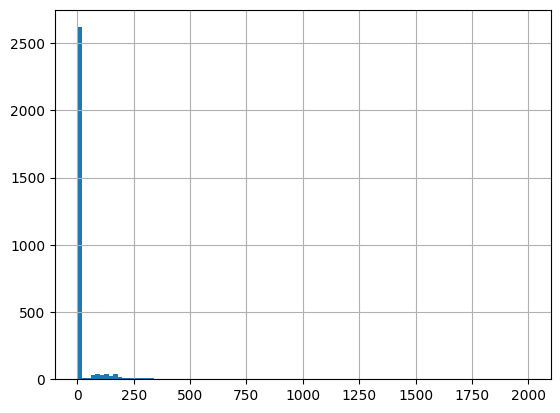

In [265]:
all_decisions['regret2'].hist(bins=100)

In [272]:
all_decisions['regret2_std_scale'] = StandardScaler().fit_transform(all_decisions['regret2'].values.reshape(-1, 1))

all_decisions['regret2_pt_scale'] = PowerTransformer().fit_transform(all_decisions['regret2'].values.reshape(-1, 1))

array([[<AxesSubplot: title={'center': 'regret2_std_scale'}>,
        <AxesSubplot: title={'center': 'regret2_pt_scale'}>]],
      dtype=object)

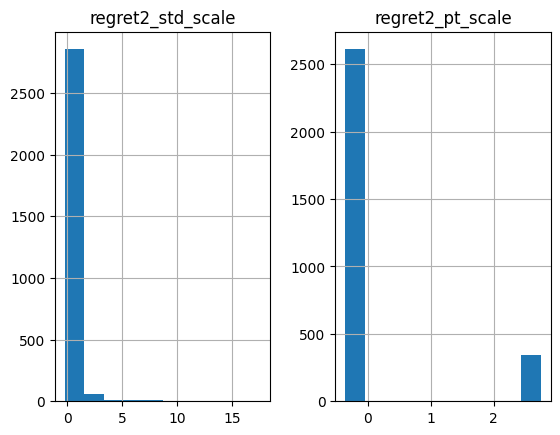

In [274]:
all_decisions[['regret2_std_scale', 'regret2_pt_scale']].hist(bins=10)

In [289]:
all_decisions['regret2_std_scale']

0      -0.227864
1            NaN
2      -0.227864
3      -0.227864
4      -0.227864
          ...   
3475   -0.227864
3476   -0.227864
3477   -0.227864
3479         NaN
3480   -0.227864
Name: regret2_std_scale, Length: 3475, dtype: float64

In [290]:
def fit_glm_for_pairwise_test(all_decisions, variants_to_compare, column):
    relevant_features = ['user_name', 'group', column, 'trx_amnt']
    
    group1 = variants_to_compare[0]
    group2 = variants_to_compare[1]
    
    row_filter = (all_decisions['group'] == group1) | (all_decisions['group'] == group2)
    
    df = all_decisions[row_filter][relevant_features]
    dummified = pd.get_dummies(df)
    
    y = dummified[column]
    X = dummified.drop(columns=column)
    
    # Dropping the control group as it is redundant
    X = X.drop('group_'+group2, axis=1)
    
    # Dropping users to see what happenes
    # X = X.drop('user_name_n', axis=1)
    # X = X.drop('user_name_j', axis=1)
    # X = X.drop('user_name_t', axis=1)

    scaler = MinMaxScaler().fit(X)
    x_scaled = scaler.transform(X)
    
    x_scaled = pd.DataFrame(x_scaled, columns=X.columns, index=X.index)
    
    x_scaled = sm.add_constant(x_scaled)
        
    mod = sm.GLM(y, x_scaled, family=sm.families.Gaussian())
    results = mod.fit()
    
    return results 

In [295]:
res = fit_linear_model_for_pairwise_test(all_decisions, ('ML Model', 'Data'), 'regret')
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 regret   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     3.217
Date:                Mon, 06 Feb 2023   Prob (F-statistic):             0.0123
Time:                        22:41:52   Log-Likelihood:                -1450.5
No. Observations:                 991   AIC:                             2911.
Df Residuals:                     986   BIC:                             2936.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.2622      0.038      6.911      0.000       0.188       0.337
trx_amnt          -0.6509      0.639     -1.019      0.309      -1.905       0.603
user_name_j        0.2471      0.049      5.080      0.000       0.152       0.343
user_name_n       -0.0115      0.049     -0.234      0.815      -0.108       0.085
user_name_t        0.0266      0.049      0.546      0.585      -0.069       0.122
group_ML Model    -0.0072      0.067     -0.108      0.914      -0.138       0.124
==============================================================================
Omnibus:                      636.465   Durbin-Watson:                   1.889
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4228.657
Skew:                           3.118   Prob(JB):                         0.00
Kurtosis:                      10.970   Cond. No.                     2.86e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.97e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [296]:
res = fit_linear_model_for_pairwise_test(all_decisions, ('TreeSHAP', 'ML Model'), 'regret')
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 regret   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.6319
Date:                Mon, 06 Feb 2023   Prob (F-statistic):              0.675
Time:                        23:00:45   Log-Likelihood:                -1505.6
No. Observations:                 994   AIC:                             3023.
Df Residuals:                     988   BIC:                             3053.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           3.209e+12      1e+13      0.321      0.749   -1.64e+13    2.28e+13
trx_amnt          -0.6625      0.718     -0.923      0.356      -2.071       0.746
user_name_j    -3.209e+12      1e+13     -0.321      0.749   -2.28e+13    1.64e+13
user_name_n    -3.209e+12      1e+13     -0.321      0.749   -2.28e+13    1.64e+13
user_name_t    -3.209e+12      1e+13     -0.321      0.749   -2.28e+13    1.64e+13
group_TreeSHAP     0.0555      0.070      0.791      0.429      -0.082       0.193
==============================================================================
Omnibus:                      603.669   Durbin-Watson:                   2.051
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3463.020
Skew:                           2.976   Prob(JB):                         0.00
Kurtosis:                       9.942   Cond. No.                     7.30e+14
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 3.04e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [297]:
res = fit_linear_model_for_pairwise_test(all_decisions, ('LIME', 'ML Model'), 'regret')
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 regret   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9792
Date:                Mon, 06 Feb 2023   Prob (F-statistic):              0.418
Time:                        23:01:12   Log-Likelihood:                -1512.0
No. Observations:                 995   AIC:                             3034.
Df Residuals:                     990   BIC:                             3059.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.2514      0.041      6.097      0.000       0.171       0.332
trx_amnt       -0.2622      0.683     -0.384      0.701      -1.603       1.079
user_name_j     0.1692      0.051      3.293      0.001       0.068       0.270
user_name_n     0.0284      0.052      0.550      0.582      -0.073       0.130
user_name_t     0.0539      0.052      1.039      0.299      -0.048       0.156
group_LIME      0.0585      0.070      0.832      0.406      -0.079       0.196
==============================================================================
Omnibus:                      599.005   Durbin-Watson:                   1.969
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3370.355
Skew:                           2.953   Prob(JB):                         0.00
Kurtosis:                       9.813   Cond. No.                     1.40e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 8.25e-28. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""